In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import statsmodels.api as sm

In [2]:
# simulate neurons over 8 trials
n_cells = 250
T = 1000 # ms
trials = 8

# random spike pattern (same for all directions)
exp = np.random.randint(2, size=(T, trials, n_cells))

In [3]:
def direction_cosines(v: np.ndarray) -> np.ndarray:
    basis = np.array([[1,0,0], [0,1,0], [0,0,1]])
    normalize = lambda v: v / np.linalg.norm(v)

    cos_x = normalize(v) @ basis[0]
    cos_y = normalize(v) @ basis[1]
    cos_z = normalize(v) @ basis[2]
    
    return np.array([cos_x, cos_y, cos_z])


vertices = [
    (1, 1, 1), 
    (-1, 1, 1), 
    (-1, -1, 1), 
    (1, -1, 1), 
    (1, 1, -1), 
    (-1, 1, -1), 
    (-1, -1, -1), 
    (1, -1, -1)
    ]


Ms = np.array([direction_cosines(v) for v in vertices])
Ms

array([[ 0.57735027,  0.57735027,  0.57735027],
       [-0.57735027,  0.57735027,  0.57735027],
       [-0.57735027, -0.57735027,  0.57735027],
       [ 0.57735027, -0.57735027,  0.57735027],
       [ 0.57735027,  0.57735027, -0.57735027],
       [-0.57735027,  0.57735027, -0.57735027],
       [-0.57735027, -0.57735027, -0.57735027],
       [ 0.57735027, -0.57735027, -0.57735027]])

In [4]:
# sanity check
for i in range(len(Ms)):
    m_x, m_y, m_z = Ms[i]
    print(np.sqrt((m_x**2 + m_y**2 + m_z**2)), end="  ")

1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

In [5]:
from sklearn.linear_model import LinearRegression

cell = exp[:,0,0]

dm = np.mean(cell).reshape(1,-1)

M = Ms[0].reshape(1,-1)

model = LinearRegression().fit(M, dm)
print(model.coef_)

[[0. 0. 0.]]


In [6]:
D = np.mean(exp[:,:,0], axis=0)
model = LinearRegression().fit(Ms, D)
print(model.coef_)

[-0.01926907  0.00584567  0.01277387]


In [7]:
def compute_direction_vector(neuron: np.ndarray, Ms: np.ndarray) -> tuple[np.ndarray, bool]:
    # mean firing rate for the 8 trials
    d_M = np.mean(neuron, axis=0)
    
    # fit linear regression
    M_ = sm.add_constant(Ms)
    model = sm.OLS(d_M, M_).fit()
    predictions = model.predict(M_)
    directional = all(model.pvalues <= 0.05) # True iff all bs below alpha lvl
    
    # extract coefficients (bs)
    b, b_x, b_y, b_z = model.params

    # direction cosines of preferred direction
    k = np.sqrt(b_x**2 + b_y**2 + b_z**2)
    C = np.array([b_x/k, b_y/k, b_z/k])
    
    # vector weight
    d_M_avg = np.mean(d_M) # average firing rate accross trials
    w_M = d_M_avg - b
    
    # wighted direction vector
    N_M = w_M * C
    
    return N_M, directional


def compute_direction_vector(neuron: np.ndarray, Ms: np.ndarray) -> tuple[np.ndarray, bool]:
    # mean firing rate for the 8 trials
    d_M = np.mean(neuron, axis=0)
    
    # fit linear regression
    Ms_ = sm.add_constant(Ms)
    model = sm.OLS(d_M, Ms_).fit()
    predictions = model.predict(Ms_)
    directional = all(model.pvalues <= 0.05) # True iff all bs below alpha lvl
    
    # extract coefficients (bs)
    b, b_x, b_y, b_z = model.params

    # direction cosines of preferred direction
    k = np.sqrt(b_x**2 + b_y**2 + b_z**2)
    C = np.array([b_x/k, b_y/k, b_z/k])
    
    # vector weight
    d_M_avg = np.mean(d_M) # average firing rate accross trials
    w_M = d_M_avg - b
    
    # wighted direction vector
    N_M = w_M * C
    
    return N_M, directional


In [9]:
vectors = np.zeros((n_cells, 3))
dirs = []
for n in range(n_cells):
    vec, directional = compute_direction_vector(exp[:,:,n], Ms)
    vectors[n,:] = vec
    dirs.append(directional)

# compute population vector
print(f"Proportion directional: {np.mean(dirs)*100}%")

population_vector = np.sum(vectors, axis=0)
print(f"Population vector: {population_vector}")

print(f"Average cell vector magnitude: {np.mean([np.linalg.norm(v) for v in vectors])}")

Proportion directional: 0.0%
Population vector: [-1.84714721e-15 -6.94139676e-17  6.82272393e-16]
Average cell vector magnitude: 1.1035616864774056e-16


1.8471472099501635e-15
2.192208153606253e-16


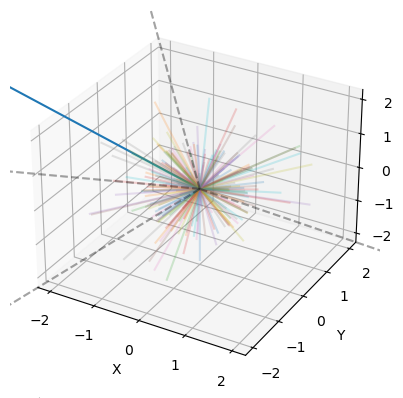

In [10]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def plot_vectors_3d(vectors, mov_axes=False):
    # Plot each vector as a line

    if mov_axes: 
        for v in vectors: 
            ax.plot([0, v[0]], [0, v[1]], [0, v[2]], alpha=0.2, linestyle='--', color='k')
        return

    if vectors.shape == (3,): # single vector
        v = vectors
        ax.plot([0, v[0]], [0, v[1]], [0, v[2]])
        max_dim = max(abs(v[0]), abs(v[1]), abs(v[2]))
    else:
        for v in vectors: ax.plot([0, v[0]], [0, v[1]], [0, v[2]], alpha=0.2)
        max_dim = max(max(abs(v[0]), abs(v[1]), abs(v[2])) for v in vectors)

    # set the limits of the plot
    ax.set_xlim([-max_dim, max_dim])
    ax.set_ylim([-max_dim, max_dim])
    ax.set_zlim([-max_dim, max_dim])
    print(max_dim) # BUG ticks are wrong?

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')


plot_vectors_3d(population_vector)
plot_vectors_3d(vectors)
plot_vectors_3d(np.array(vertices), mov_axes=True)

### compute angle

In [11]:
def compute_angle(v1: np.ndarray, v2: np.ndarray):
    normalize = lambda v: v / np.linalg.norm(v)
    # v1_u, v2_u = v1, v2
    v1_u, v2_u = normalize(v1), normalize(v2)
    return np.arccos(np.clip((v1_u @ v2_u), -1.0, 1.0))

for vertex in vertices:
    angle = np.degrees(compute_angle(population_vector, vertex))
    print(f"Angle between vertex {vertex} and population vector: {angle}")

Angle between vertex (1, 1, 1) and population vector: 111.20284226988385
Angle between vertex (-1, 1, 1) and population vector: 43.87695938265026
Angle between vertex (-1, -1, 1) and population vector: 40.40257296050378
Angle between vertex (1, -1, 1) and population vector: 108.72289791046451
Angle between vertex (1, 1, -1) and population vector: 139.59742703949624
Angle between vertex (-1, 1, -1) and population vector: 71.27710208953549
Angle between vertex (-1, -1, -1) and population vector: 68.79715773011615
Angle between vertex (1, -1, -1) and population vector: 136.12304061734974


## non-random spike trains

In [12]:
# simulate neurons over 8 trials
n_cells = 250
T = 1000 # ms
trials = 8

exp = np.zeros((T, trials, n_cells))

# 8 trials, each involves movement in specific direction
# -> on each trial only a select population responds

# exp[:, 0, 0:25] = np.random.randint(2, size=(T, trials, 25))
# exp[:, 1, 25:50] = np.random.randint(2, size=(T, trials, 25))
# ...

for t, cell in zip(range(trials), range(0, n_cells, 25)):
    exp[:, t, cell:cell+25] = np.random.randint(2, size=(T, 25))

In [ ]:
def plot_3d_array(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = np.indices(data.shape)
    ax.scatter(x.flatten(), y.flatten(), z.flatten(), c=data.flatten())


# plot_3d_array(exp)

cells 0 - 175 are directionally tuned, the rest are not

In [14]:
vectors = np.zeros((n_cells, 3))
dirs = []
for n in range(n_cells):
    vec, directional = compute_direction_vector(exp[:,:,n], Ms)
    vectors[n,:] = vec
    dirs.append(directional)

# compute population vector
print(f"Proportion directional: {np.mean(dirs)*100}%")

population_vector = np.sum(vectors, axis=0)
print(f"Population vector: {population_vector}")

print(f"Average cell vector magnitude: {np.mean([np.linalg.norm(v) for v in vectors])}")

Proportion directional: 0.0%
Population vector: [nan nan nan]
Average cell vector magnitude: nan


/var/folders/zj/mv8z2fl52v172cdpjlkt5cj00000gn/T/ipykernel_4169/590117861.py:43: RuntimeWarning: invalid value encountered in scalar divide
  C = np.array([b_x/k, b_y/k, b_z/k])
/var/folders/zj/mv8z2fl52v172cdpjlkt5cj00000gn/T/ipykernel_4169/590117861.py:43: RuntimeWarning: invalid value encountered in scalar divide
  C = np.array([b_x/k, b_y/k, b_z/k])
/var/folders/zj/mv8z2fl52v172cdpjlkt5cj00000gn/T/ipykernel_4169/590117861.py:43: RuntimeWarning: invalid value encountered in scalar divide
  C = np.array([b_x/k, b_y/k, b_z/k])
/var/folders/zj/mv8z2fl52v172cdpjlkt5cj00000gn/T/ipykernel_4169/590117861.py:43: RuntimeWarning: invalid value encountered in scalar divide
  C = np.array([b_x/k, b_y/k, b_z/k])
/var/folders/zj/mv8z2fl52v172cdpjlkt5cj00000gn/T/ipykernel_4169/590117861.py:43: RuntimeWarning: invalid value encountered in scalar divide
  C = np.array([b_x/k, b_y/k, b_z/k])
/var/folders/zj/mv8z2fl52v172cdpjlkt5cj00000gn/T/ipykernel_4169/590117861.py:43: RuntimeWarning: invalid value

In [ ]:
M_ = sm.add_constant(M)
model = sm.OLS(d_M, M_).fit()
predictions = model.predict(M_) 
 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.111
Date:                Tue, 09 May 2023   Prob (F-statistic):              0.443
Time:                        20:20:51   Log-Likelihood:                 31.198
No. Observations:                   8   AIC:                            -54.40
Df Residuals:                       4   BIC:                            -54.08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0500      0.002     20.412      0.0

/opt/miniconda3/envs/fmri/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
